In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Задание 1 
ВЫПУКЛАЯ ОБОЛОЧКА  ПОСЛЕДОВАТЕЛЬНО ПОСТУПАЮЩИХ ТОЧЕК ПЛОСКОСТИ 

In [2]:
class PolygonHull:
    def __init__(self, vertices=None):
        """
        Инициализация выпуклой оболочки.
        :param vertices: numpy-массив начальных точек (Nx2), или None.
        """
        self.points = np.array(vertices) if vertices is not None else np.empty((0, 2))
        self.border_length = 0.0  # Периметр оболочки
        self.enclosed_area = 0.0  # Площадь оболочки

    @staticmethod
    def check_orientation(pt1, pt2, pt3):
        """
        Проверяет ориентацию трёх точек.
        :param pt1: numpy-массив точки [x, y].
        :param pt2: numpy-массив точки [x, y].
        :param pt3: numpy-массив точки [x, y].
        :return: 0 если на одной линии, 1 для против часовой, -1 для по часовой.
        """
        delta = (pt2[1] - pt1[1]) * (pt3[0] - pt2[0]) - (pt3[1] - pt2[1]) * (pt2[0] - pt1[0])
        if delta == 0:
            return 0
        return 1 if delta > 0 else -1

    @staticmethod
    def squared_distance(v1, v2):
        """
        Возвращает квадрат расстояния между двумя точками.
        :param v1: numpy-массив точки [x, y].
        :param v2: numpy-массив точки [x, y].
        :return: float, квадрат расстояния.
        """
        delta = v1 - v2
        return np.dot(delta, delta)

    def _recalculate_properties(self):
        """
        Пересчитывает периметр и площадь оболочки.
        """
        if len(self.points) < 3:
            self.border_length = 0.0
            self.enclosed_area = 0.0
            return

        # Периметр
        self.border_length = np.sum(
            np.linalg.norm(self.points - np.roll(self.points, -1, axis=0), axis=1)
        )

        # Площадь (через формулу шнурков)
        x, y = self.points[:, 0], self.points[:, 1]
        self.enclosed_area = 0.5 * abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

    def contains_point(self, vertex):
        """
        Проверяет, находится ли точка внутри оболочки.
        :param vertex: numpy-массив точки [x, y].
        :return: True, если внутри; False, если снаружи.
        """
        if len(self.points) < 3:
            return False

        centroid = np.mean(self.points, axis=0)  # Центроид оболочки
        for i in range(len(self.points)):
            j = (i + 1) % len(self.points)
            a, b = self.points[i], self.points[j]
            orient_to_centroid = self.check_orientation(a, b, centroid)
            orient_to_vertex = self.check_orientation(a, b, vertex)
            if orient_to_centroid * orient_to_vertex < 0:
                return False
        return True

    def insert_vertex(self, vertex):
        """
        Добавляет точку в оболочку.
        :param vertex: numpy-массив точки [x, y].
        """
        vertex = np.array(vertex)
        if self.points.size == 0:
            print(f"Добавлена первая точка: {vertex}")
            self.points = np.array([vertex])
        elif len(self.points) == 1:
            if not np.array_equal(self.points[0], vertex):
                print(f"Оболочка изменилась")
                print(f"Добавлена вторая точка: {vertex}")
                self.points = np.vstack([self.points, vertex])
            else:
                print(f"Оболочка не изменилась")
        elif len(self.points) == 2:
            if self.check_orientation(self.points[0], self.points[1], vertex) == 0:
                sorted_pts = sorted([self.points[0], self.points[1], vertex], key=lambda p: (p[0], p[1]))
                self.points = np.array([sorted_pts[0], sorted_pts[-1]])
            elif self.check_orientation(self.points[0], self.points[1], vertex) >= 0:
                newpoints = [self.points[0], vertex, self.points[1]]
                self.points = np.array(newpoints)
            else:
                self.points = np.vstack([self.points, vertex])
        else:
            if self.contains_point(vertex):
                print(f"Оболочка не изменилась")
                return

            distances = np.array([self.squared_distance(vertex, p) for p in self.points])
            nearest_idx = np.argmin(distances)

            n = len(self.points)
            upper = nearest_idx
            while self.check_orientation(vertex, self.points[upper], self.points[(upper + 1) % n]) >= 0:
                upper = (upper + 1) % n

            lower = nearest_idx
            while self.check_orientation(vertex, self.points[lower], self.points[(lower - 1) % n]) <= 0:
                lower = (lower - 1) % n

            new_hull = []
            current = upper
            new_hull.append(self.points[current])
            while current != lower:
                current = (current + 1) % n
                new_hull.append(self.points[current])
            new_hull.append(vertex)
            self.points = np.array(new_hull)
            print(f"Оболочка изменилась")
            print(f"Добавлена точка {len(self.points)}: {vertex}")

        self._recalculate_properties()

    def fetch_properties(self):
        """
        Возвращает текущие свойства оболочки.
        :return: dict с периметром, площадью и точками оболочки.
        """
        return {
            "points": self.points,
            "border_length": self.border_length,
            "enclosed_area": self.enclosed_area,
        }

    def display_hull(self):
        """
        Визуализирует текущую оболочку.
        """
        plt.figure(figsize=(6, 6))
        hull_vertices = self.fetch_properties()["points"]
        plt.scatter(self.points[:, 0], self.points[:, 1], color='blue', label='Точки')
        if len(hull_vertices) > 0:
            hull_vertices = np.vstack([hull_vertices, hull_vertices[0]])
            plt.plot(hull_vertices[:, 0], hull_vertices[:, 1], color='red', label='Оболочка')
        if len(self.points) == 1:
            plt.title("Одноугольник")
        elif len(self.points) == 2:
            plt.title("Двуугольник")
        else:
            plt.title(f"Многоугольник с {len(self.points)} точками")
        plt.legend()
        plt.grid(True)
        plt.show()


In [3]:
c2 = PolygonHull()
c2.insert_vertex([0,0])
c2.insert_vertex([1,0])
c2.insert_vertex([0.5,1])

Добавлена первая точка: [0 0]
Оболочка изменилась
Добавлена вторая точка: [1 0]


In [4]:
c2.points

array([[0. , 0. ],
       [1. , 0. ],
       [0.5, 1. ]])

In [5]:
c2.insert_vertex([1,0])

Оболочка не изменилась


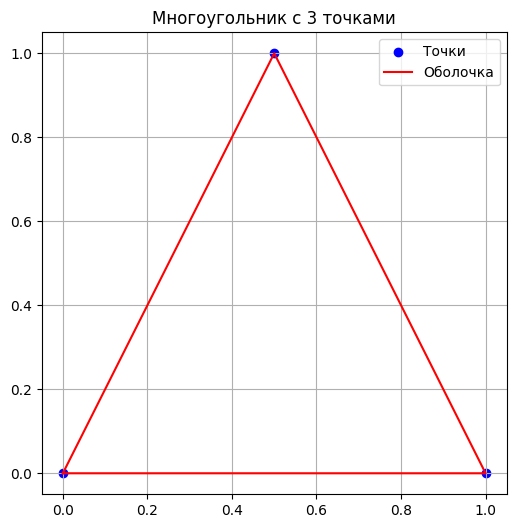

In [6]:
c2.display_hull()

In [7]:
c2.insert_vertex([1,1])

Оболочка изменилась
Добавлена точка 4: [1 1]


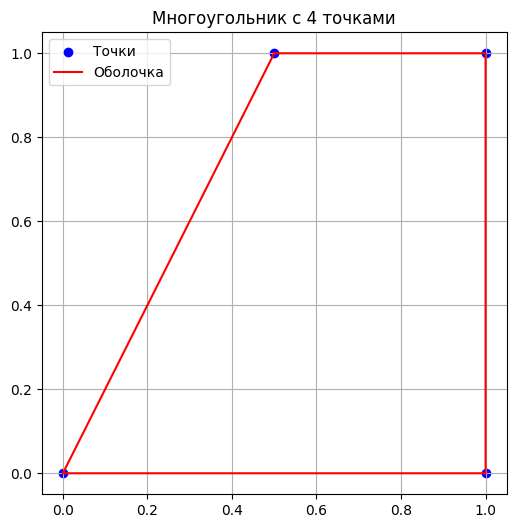

In [8]:
c2.display_hull()

In [9]:
points = np.random.randint(1, 100, (50, 2))

In [10]:
p = PolygonHull()

In [11]:
for point in points:
    p.insert_vertex(point)

Добавлена первая точка: [51 16]
Оболочка изменилась
Добавлена вторая точка: [19  5]
Оболочка изменилась
Добавлена точка 3: [62 82]
Оболочка изменилась
Добавлена точка 4: [74 73]
Оболочка изменилась
Добавлена точка 4: [7 4]
Оболочка изменилась
Добавлена точка 5: [11 57]
Оболочка не изменилась
Оболочка не изменилась
Оболочка изменилась
Добавлена точка 6: [91 24]
Оболочка изменилась
Добавлена точка 6: [86 82]
Оболочка не изменилась
Оболочка не изменилась
Оболочка изменилась
Добавлена точка 6: [ 9 69]
Оболочка не изменилась
Оболочка изменилась
Добавлена точка 6: [94  6]
Оболочка изменилась
Добавлена точка 6: [74 94]
Оболочка изменилась
Добавлена точка 7: [50 96]
Оболочка изменилась
Добавлена точка 8: [ 2 21]
Оболочка изменилась
Добавлена точка 8: [ 5 91]
Оболочка не изменилась
Оболочка не изменилась
Оболочка не изменилась
Оболочка не изменилась
Оболочка не изменилась
Оболочка изменилась
Добавлена точка 9: [14  2]
Оболочка изменилась
Добавлена точка 8: [86 94]
Оболочка не изменилась
Оболочк

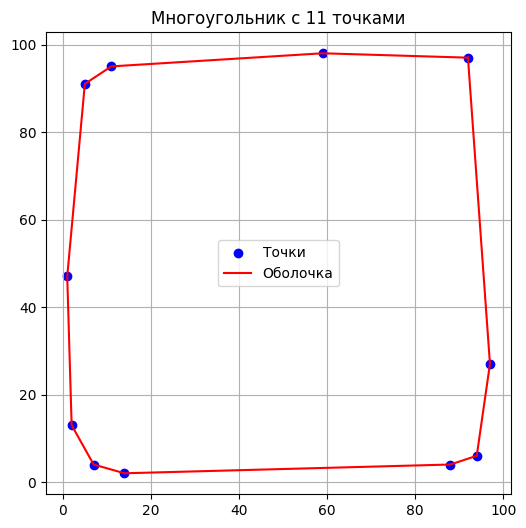

In [12]:
p.display_hull()

In [13]:
p_test = PolygonHull(points)

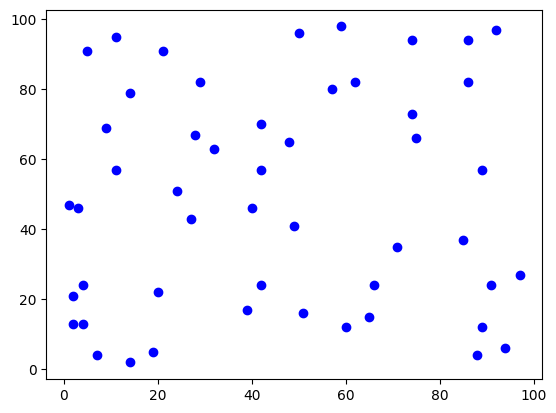

In [19]:
plt.scatter(points[:, 0], points[:, 1], c='b')